In [8]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost, measure_local_observables, cLns, set_n0
import yastn
from yastn.tn import mps

In [33]:
g = 1
v, Q = 1, 1
N = 256
a = 0.125
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{v=:0.4f}", f"{Q=:0.4f}", f"{a=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]

In [34]:
D = 128
ms = [0, 0.5]
#
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])
#
d_gs = {}
for m in ms:
    d_gs[m] = np.load(fn_mass(fgs, m=m ), allow_pickle=True).item()


In [41]:
Ds = [128, 256, 512]
ts = np.linspace(0, 15, 16)
ms = [0, 0.5]
psi_t = {(m, t, D): yastn.from_dict(np.load(fn_mass(fns, t=t, D=D, m=m), allow_pickle=True).item()['psi']) for t in ts for D in Ds for m in ms}

In [12]:
SV_t = {k: v.get_Schmidt_values() for k, v in psi_t.items()}

In [35]:
def Ln_from_tt(N, n, tt, time=0, a=0.125, v=1, Q=0):
    cst = cLns(N, time, set_n0(N), a, v, Q)
    if isinstance(tt, (tuple)):
        tt = tt[0]
    cc = cst[n] if n >= 0 else 0
    Ln = N // 2 - tt + cc
    return Ln


In [36]:
dist_Ln = {}
for k, SV in SV_t.items():
    m, time, D = k
    dist_Ln[k] = {n: {Ln_from_tt(N, n, tt, time, a, v, Q): np.sum(ten[tt + tt] ** 2) for tt in ten.get_legs(axes=0).t} for n, ten in enumerate(SV, start=-1)}

In [39]:
LLs = [-2, -1, 0, 1, 2]
dist_Ln_plot = {k: {l: np.zeros(N+1) for l in LLs} for k in dist_Ln}

for k, Lns in dist_Ln.items():
    for l in LLs:
        for n, pl in Lns.items():
            if l in pl:
                dist_Ln_plot[k][l][n+1] = pl[l]


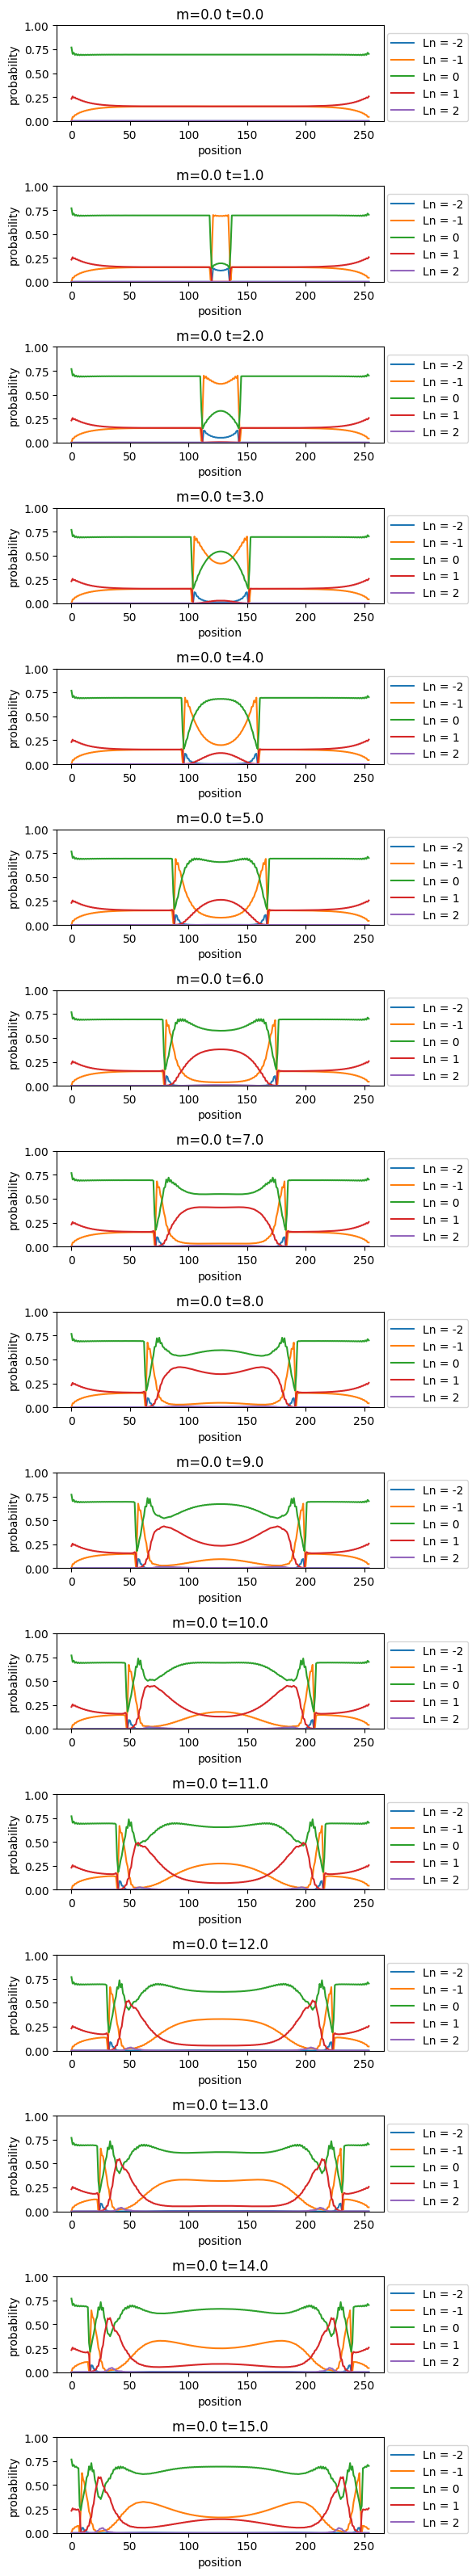

In [42]:
m = 0
fig, ax = plt.subplots(len(ts),1)
fig.set_size_inches(6, 2*len(ts))
for ii, t in enumerate(ts):
    for l, pl in dist_Ln_plot[m, t, 512].items():
        ax[ii].plot( (pl[0:-2] + pl[1:-1]) / 2, label=f'Ln = {l}')
    ax[ii].set_title(f"{m=:0.1f} {t=:0.1f}")
    ax[ii].set_ylim([0, 1])
    ax[ii].set_ylabel('probability')
    ax[ii].set_xlabel('position')
    ax[ii].legend(loc=(1.01, 0))
fig.tight_layout()


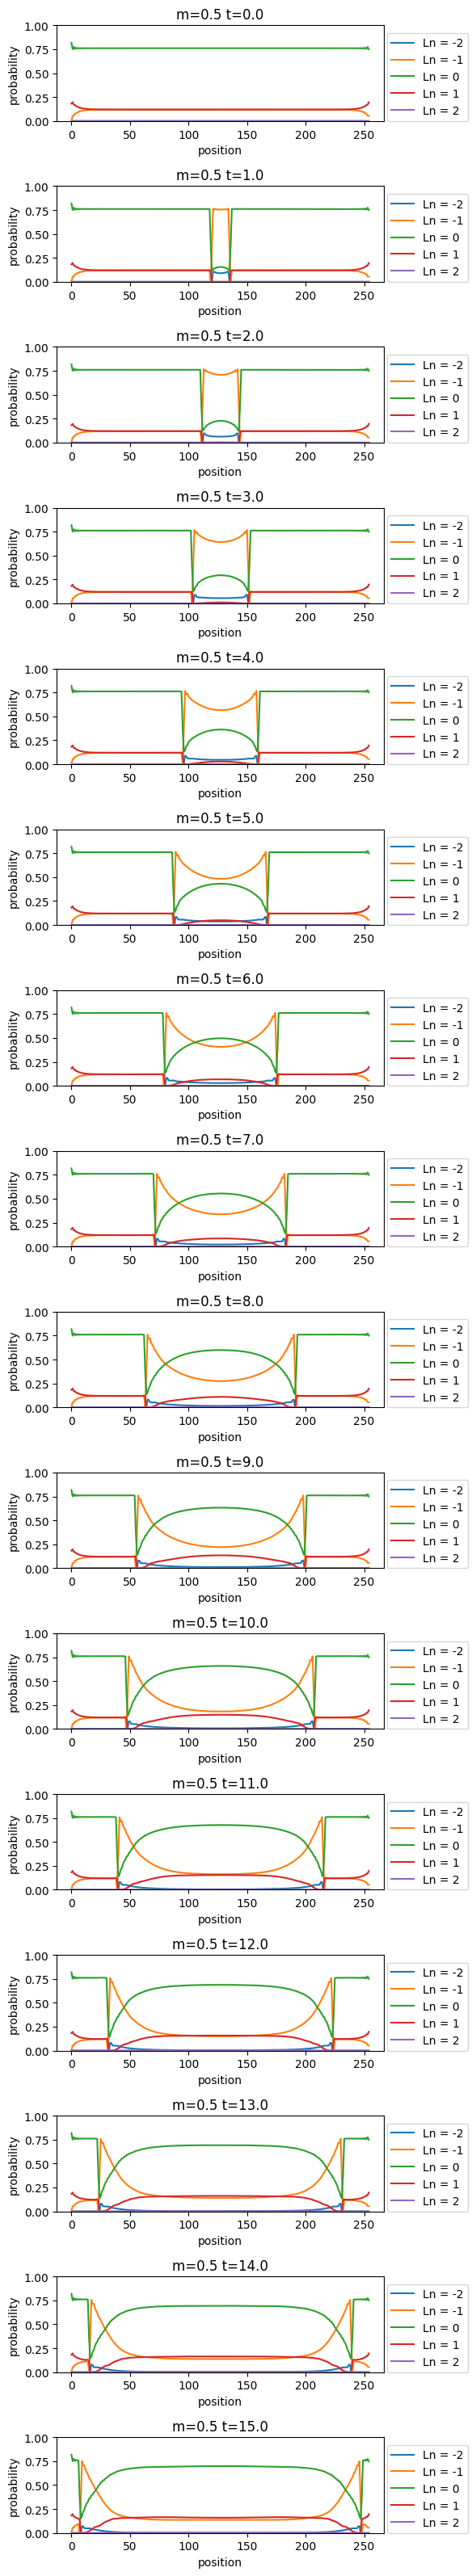

In [43]:
m = 0.5
fig, ax = plt.subplots(len(ts),1)
fig.set_size_inches(6, 2*len(ts))
for ii, t in enumerate(ts):
    for l, pl in dist_Ln_plot[m, t, 512].items():
        ax[ii].plot( (pl[0:-2] + pl[1:-1]) / 2, label=f'Ln = {l}')
    ax[ii].set_title(f"{m=:0.1f} {t=:0.1f}")
    ax[ii].set_ylim([0, 1])
    ax[ii].set_ylabel('probability')
    ax[ii].set_xlabel('position')
    ax[ii].legend(loc=(1.01, 0))
fig.tight_layout()
